In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [2]:
pbp_basic = pd.read_csv('../../Data/play-by-play/processed_pbp_dataset.csv')

categorical_cols = ['OffenseTeam', 'DefenseTeam', 'play_type', 'side_of_field','stadium','play_type_nfl','roof','surface_type','home_team', 'away_team','season_type']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    pbp_basic[col] = le.fit_transform(pbp_basic[col].astype(str))
    label_encoders[col] = le  # Save encoders if needed later

In [3]:
X = pbp_basic.drop(columns=['Player-Injured-On-Play', 'date', 'play_id', 'game_id', 'old_game_id', 'Description',
                            'drive_time_of_possession', 'num_injuries'])

X = pbp_basic[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type',
               'HOME_day_since_last_game', 'AWAY_day_since_last_game']]

y = pbp_basic['Player-Injured-On-Play']

k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # Stratified K-Fold

accuracy_scores = []
precision_scores = []
recall_scores = []
feature_importances = np.zeros(len(X.columns))

# stratified K-Fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]  # Injured plays
    X_train_neg = X_train[y_train == 0]  # Non-injured plays
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # **Resample to ensure 1619 injured and 1619 non-injured plays in training and testing**
    
    # Oversample positive cases (injured plays, all 1619)
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, 
                                                             replace=True, n_samples=1619, random_state=42)

    # Undersample negative cases (non-injured plays) to 1619
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, 
                                                             replace=False, n_samples=1619, random_state=42)
    
    # Apply the same strategy to the test set
    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, 
                                                           replace=True, n_samples=1619, random_state=42)
    
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, 
                                                           replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_resampled, y_train_resampled)     # Train Decision Tree 
    feature_importances += dt_model.feature_importances_
    
    y_pred = dt_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

feature_importances /= k
# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')

Accuracy scores for each fold: [0.5271772699197035, 0.5392217418159357, 0.5250154416306362, 0.4827053736874614, 0.5571340333539222, 0.5546633724521309, 0.5024706609017913, 0.4972205064854849, 0.4762198888202594, 0.46757257566399013, 0.4993823347745522, 0.5138974675725757, 0.5765904879555281, 0.5284126003705991, 0.5725756639901174, 0.496911673872761, 0.515750463248919, 0.4740580605311921, 0.5775169857936998, 0.4666460778258184, 0.544780728844966, 0.5327362569487338, 0.5503397158739963, 0.5145151327980235, 0.5018529956763434, 0.42927733168622606, 0.5948116121062385, 0.5453983940704138, 0.5188387893761581, 0.5148239654107474, 0.5568252007411982, 0.5784434836318715, 0.5129709697344039, 0.49876466954910437, 0.5716491661519456, 0.5373687461395923, 0.5472513897467572, 0.5583693638048178, 0.6253860407659049, 0.5077208153180975, 0.5216182828906732, 0.5030883261272391, 0.4570722668313774, 0.5676343421865349, 0.5142063001852996, 0.4947498455836936, 0.5518838789376158, 0.5287214329833231, 0.527486

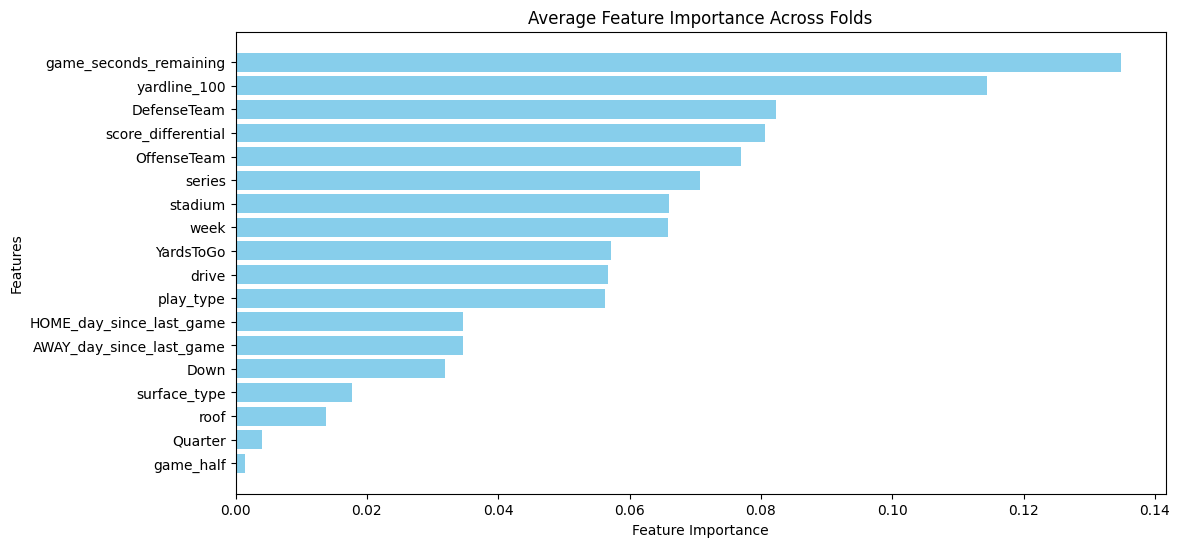

In [22]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()